<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/fix%2Fmetrics/experiments/experiment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Experiment 6

### 0. Prepare Colab, Define Constants

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#! ls
%cd drive/MyDrive/MachineLearning/
#! git clone https://github.com/emely3h/Geospatial_ML.git
%cd Geospatial_ML
! ls
#! git pull
! git checkout fix/metrics

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
data_exploration  evaluation   models	    prepare_data    README.md
docs		  experiments  poetry.lock  pyproject.toml  requirements.txt
Already on 'fix/metrics'
Your branch is up to date with 'origin/fix/metrics'.


In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import Sequence
from datetime import datetime
from models.unet_model import unet_2d
from evaluation.evaluation_metrics import EvaluationMetrics
from data_exploration.mask_stats import Mask_Stats
from tensorflow.keras.models import load_model
from models.helpers import save_metrics, predictions_for_models
from evaluation.helpers import plot_metrics, load_metrics_into_df, calc_save_metrics_pred
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [4]:
total_tiles = 11121
train_tiles = 6672
test_val_tiles = 2224
data_path = "../data_colab/256_256"
experiment = "experiment_6"
batch_size = 32
tile_size = 256
step_size = 256

### 1. Create Data Generators

In [5]:
train_split_x = np.memmap(os.path.join(data_path, "train_split_x.npy"), mode="r", shape=(train_tiles, 256, 256, 5), dtype=np.uint8)
train_split_y = np.memmap(os.path.join(data_path, "train_split_y.npy"), mode="r", shape=(train_tiles, 256, 256), dtype=np.uint8)
val_split_x = np.memmap(os.path.join(data_path, "val_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.uint8)
val_split_y = np.memmap(os.path.join(data_path, "val_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.uint8)
test_split_x = np.memmap(os.path.join(data_path, "test_split_x.npy"), mode="r", shape=(test_val_tiles, 256, 256, 5), dtype=np.uint8)
test_split_y = np.memmap(os.path.join(data_path, "test_split_y.npy"), mode="r", shape=(test_val_tiles, 256, 256), dtype=np.uint8)

train_stats = Mask_Stats(train_split_y)
train_stats.print_stats()
print()
val_stats = Mask_Stats(val_split_y)
val_stats.print_stats()
print()
test_stats = Mask_Stats(test_split_y)
test_stats.print_stats()

Shape: (6672, 256, 256)
Land pixels: 195058814  44.610 %
Valid pixels: 138904480  31.767 %
Invalid pixels: 103292898  23.623 %
Sum: 6672

Shape: (2224, 256, 256)
Land pixels: 65320265  44.816 %
Valid pixels: 46246663  31.730 %
Invalid pixels: 34185136  23.454 %
Sum: 2224

Shape: (2224, 256, 256)
Land pixels: 64786699  44.450 %
Valid pixels: 46892391  32.173 %
Invalid pixels: 34072974  23.377 %
Sum: 2224


In [6]:
class DataGenerator(Sequence):
    def __init__(self, mmap_x, mmap_y, batch_size):
        self.x_input = mmap_x
        self.y_mask = mmap_y
        self.batch_size = batch_size
        self.num_samples = self.x_input.shape[0]

    # returns number of batches as int    
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    # returns single batch
    def __getitem__(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]

        # normalization
        batch_inputs = batch_inputs/255
        # one-hot-encoding
        batch_masks = np.array([tf.one_hot(item, depth=3).numpy() for item in batch_masks])      
        
        # normalization + one hot encoding
        return batch_inputs, batch_masks
    
    def getitem_as_img(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.x_input[batch_indices]
        batch_masks = self.y_mask[batch_indices]
        # normalization + one hot encoding
        return batch_inputs, batch_masks

In [7]:
# instanciate DataGenerators
batch_size = 32

train_generator = DataGenerator(train_split_x, train_split_y, batch_size)
val_generator = DataGenerator(val_split_x, val_split_y, batch_size)
test_generator = DataGenerator(test_split_x, test_split_y, batch_size)

print(train_generator.__len__())
print(val_generator.__len__())
print(test_generator.__len__())

209
70
70


In [8]:
train_batch = train_generator.__getitem__(9)
val_batch = val_generator.__getitem__(3)
test_batch = test_generator.__getitem__(4)

def print_batch_shapes(batch):
  print(type(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print()

# check batch shapes
print_batch_shapes(train_batch)
print_batch_shapes(val_batch)
print_batch_shapes(test_batch) 

# check normalization
print('Check normalization')
print(train_batch[1].max())
print(train_batch[1].min())

print(val_batch[1].max())
print(val_batch[1].min())

print(test_batch[1].max())
print(test_batch[1].min())

print()
# check one-hot-encoding
print('check one hot encoding')
print(train_batch[0].max())
print(train_batch[0].min())

print(val_batch[0].max())
print(val_batch[0].min())

print(test_batch[0].max())
print(test_batch[0].min())

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

Check normalization
1.0
0.0
1.0
0.0
1.0
0.0

check one hot encoding
1.0
0.0
1.0
0.0
1.0
0.0


### 2. Display Images

In [9]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

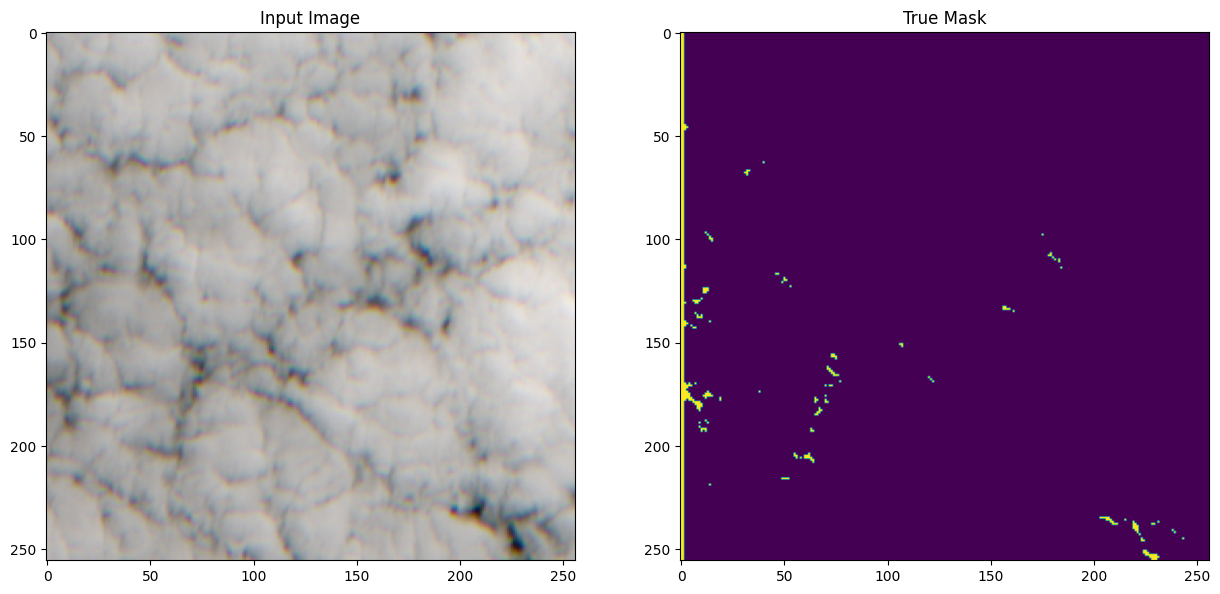

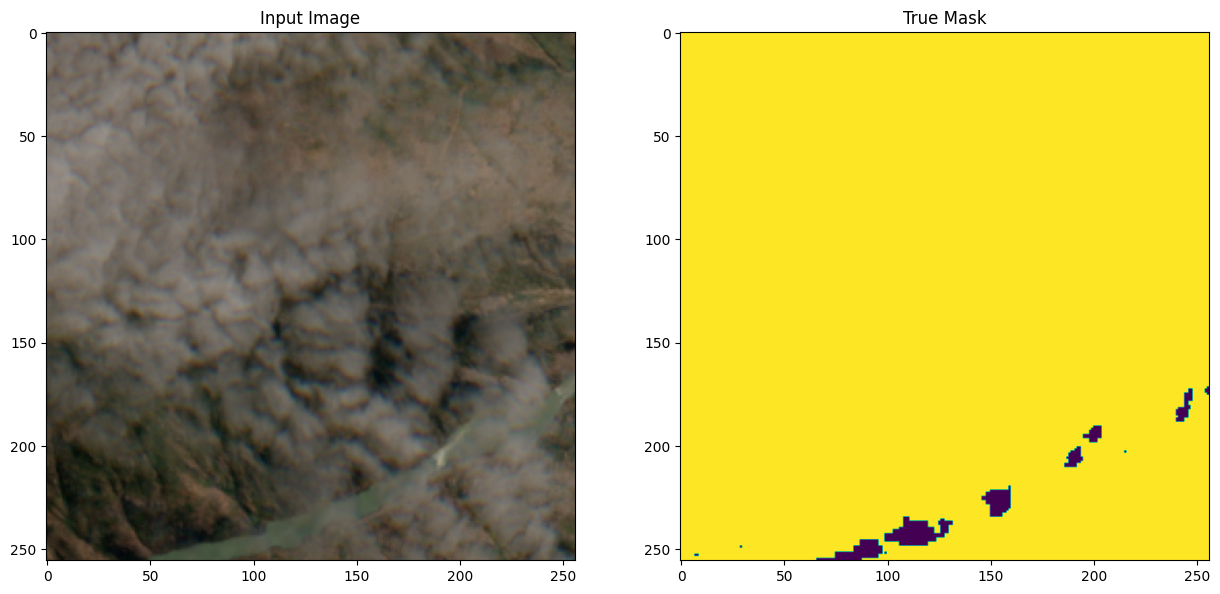

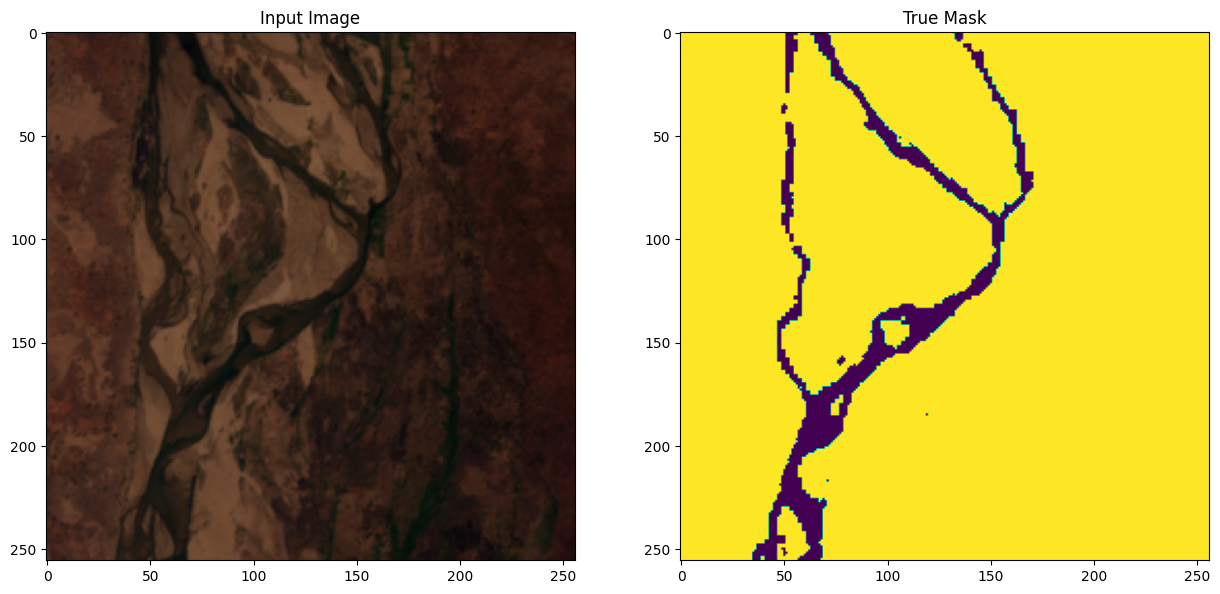

In [10]:
train_batch_img = train_generator.getitem_as_img(10)

display(train_batch_img[0][:3], train_batch_img[1][:3])

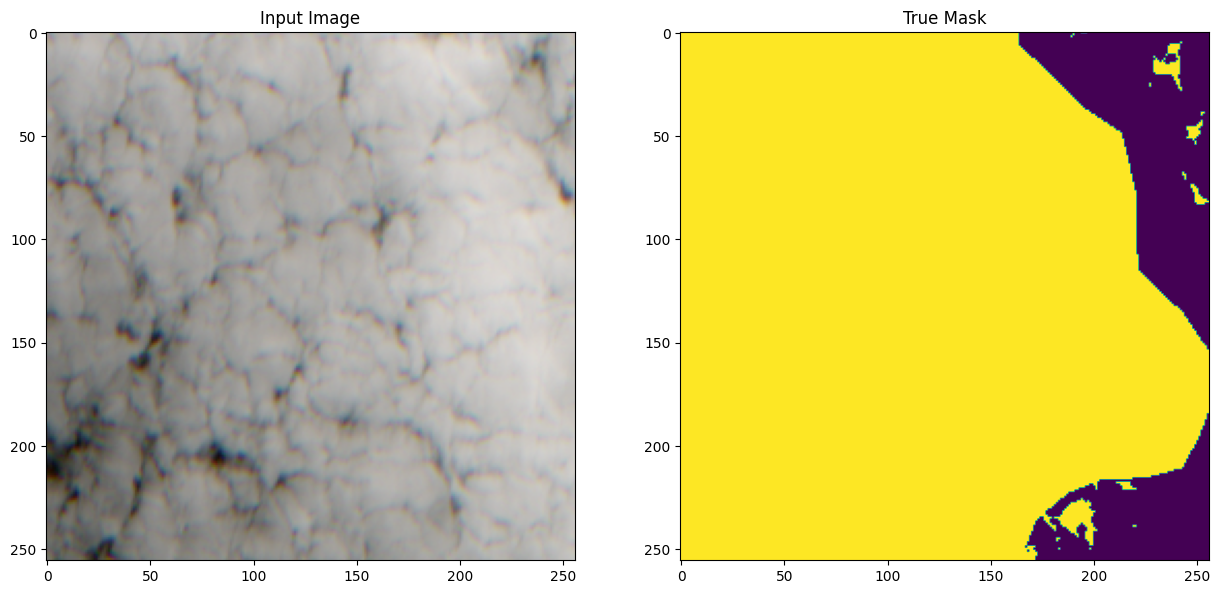

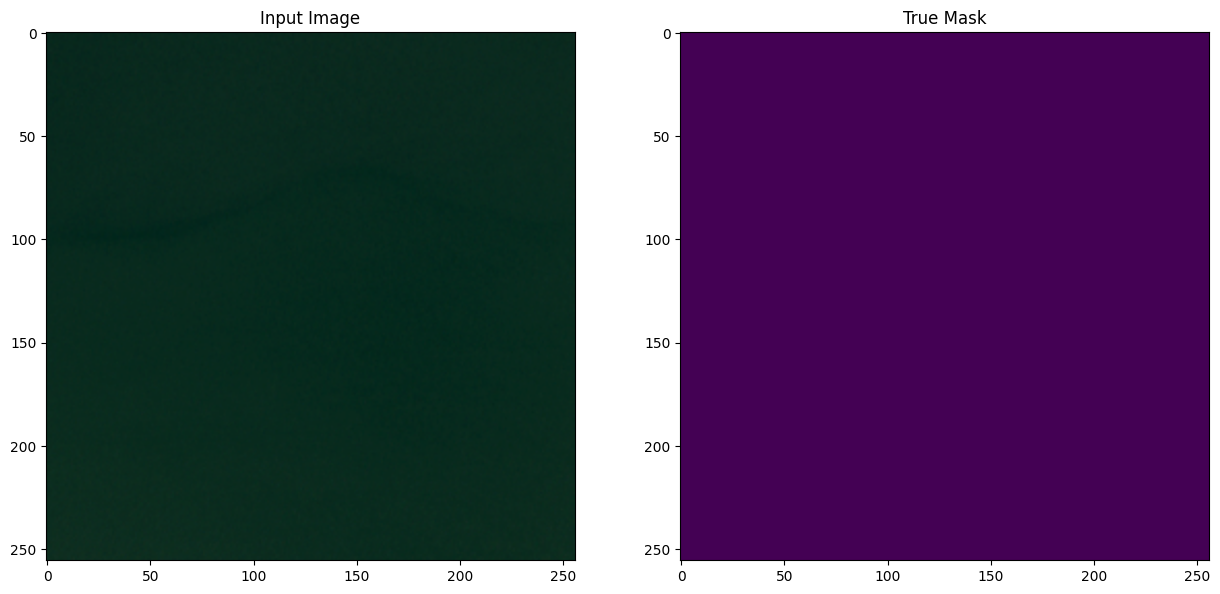

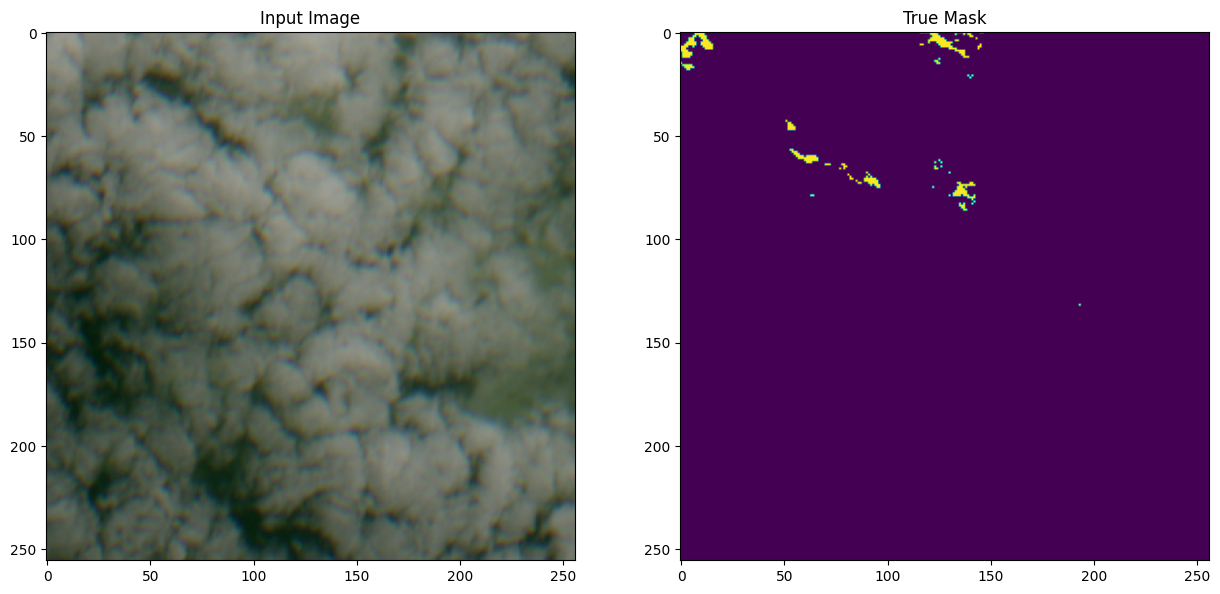

In [11]:
val_batch_img = val_generator.getitem_as_img(2)

display(val_batch_img[0][:3], val_batch_img[1][:3])

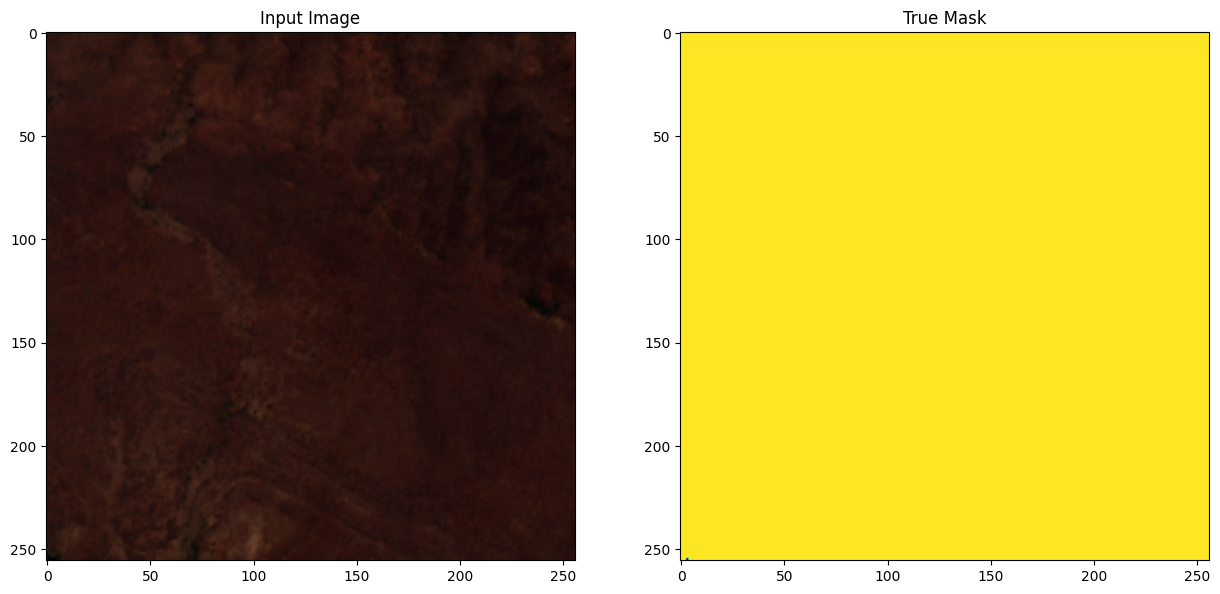

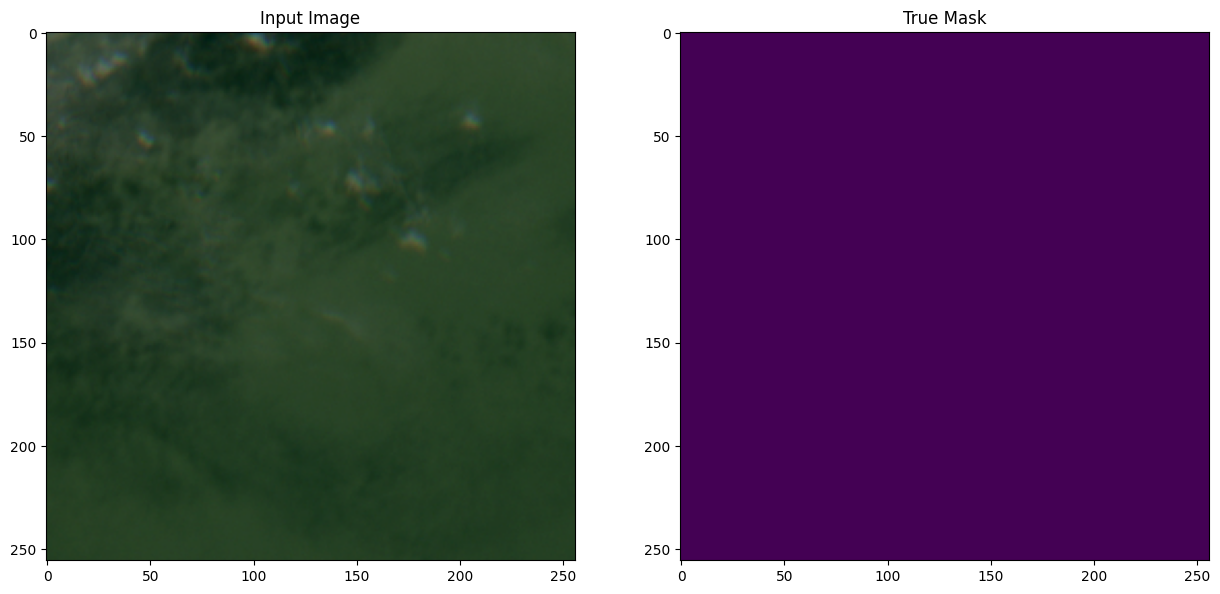

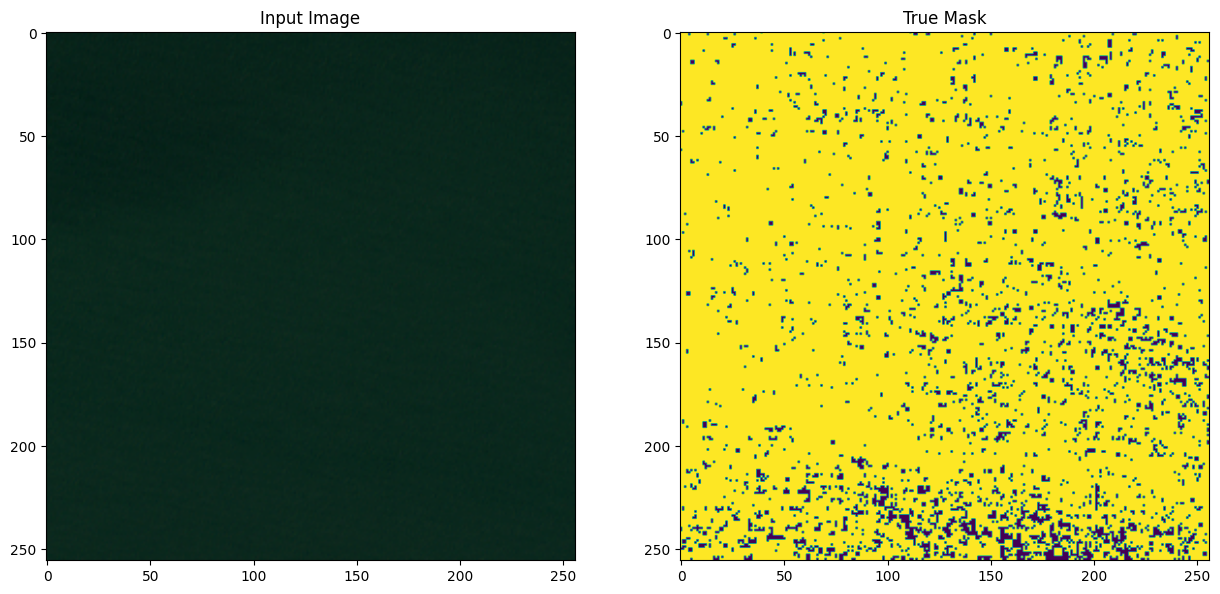

In [12]:
test_batch_img = test_generator.getitem_as_img(4)

display(test_batch_img[0][:3], test_batch_img[1][:3])

### 3. Model training
execute with premium GPU, High RAM

In [13]:
!nvidia-smi

Sun May  7 13:24:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    51W / 400W |    693MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
count = 3
model_name = f'{tile_size}_{step_size}_run_{count}'
model_path = f'../models/{experiment}/model_{model_name}.h5'


print(f'Started at: {datetime.now()}')

# Define the mIoU metric
mean_iou = tf.keras.metrics.OneHotMeanIoU(num_classes=3, name='mean_iou')
invalid_iou = tf.keras.metrics.OneHotIoU(num_classes=3, target_class_ids=[0], name='invalid_iou')
valid_iou = tf.keras.metrics.OneHotIoU(num_classes=3, target_class_ids=[1], name='valid_iou')
land_iou = tf.keras.metrics.OneHotIoU(num_classes=3, target_class_ids=[2], name='land_iou')


# compiling model
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=[mean_iou, invalid_iou, valid_iou, land_iou, 'accuracy'])

#model.summary()

# callbacks
early_stop_loss = EarlyStopping(monitor='val_loss', mode='min', patience=15)
early_stop_acc = EarlyStopping(monitor='val_mean_iou', mode='max', patience=15) 
checkpoint = ModelCheckpoint(model_path, monitor="val_mean_iou", mode="max", save_best_only=True, verbose=1)

# training
model_history = model.fit(x=train_generator, epochs=100, validation_data=val_generator, 
                          callbacks=[early_stop_loss, early_stop_acc, checkpoint])


# Save model history
with open(f'../models/{experiment}/history_{model_name}.pkl', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)
print('saving history completed')

print(f'Finished at: {datetime.now()}')

Started at: 2023-05-07 13:24:30.040987
Epoch 1/100
209/209 [==============================] - ETA: 0s - loss: 0.2598 - mean_iou: 0.7950 - invalid_iou: 0.6818 - valid_iou: 0.7695 - land_iou: 0.9336 - accuracy: 0.9003
Epoch 1: val_mean_iou improved from -inf to 0.88477, saving model to ../models/experiment_6/model_256_256_run_3.h5
209/209 [==============================] - 118s 434ms/step - loss: 0.2598 - mean_iou: 0.7950 - invalid_iou: 0.6818 - valid_iou: 0.7695 - land_iou: 0.9336 - accuracy: 0.9003 - val_loss: 0.1522 - val_mean_iou: 0.8848 - val_invalid_iou: 0.7947 - val_valid_iou: 0.8729 - val_land_iou: 0.9867 - val_accuracy: 0.9496
Epoch 2/100
209/209 [==============================] - ETA: 0s - loss: 0.1321 - mean_iou: 0.8968 - invalid_iou: 0.8178 - valid_iou: 0.8851 - land_iou: 0.9874 - accuracy: 0.9546
Epoch 2: val_mean_iou improved from 0.88477 to 0.90237, saving model to ../models/experiment_6/model_256_256_run_3.h5
209/209 [==============================] - 68s 324ms/step - los

training 2: increasing early stopping to 15 adding metrics

In [19]:
print(model.metrics_names)

['loss', 'mean_iou', 'invalid_iou', 'valid_iou', 'land_iou', 'accuracy']


In [20]:
print(model.evaluate(train_generator, verbose = 2))

209/209 - 33s - loss: 0.0244 - mean_iou: 0.9798 - invalid_iou: 0.9652 - valid_iou: 0.9751 - land_iou: 0.9990 - accuracy: 0.9916 - 33s/epoch - 159ms/step
[0.024375997483730316, 0.9797683358192444, 0.9651793837547302, 0.9751458168029785, 0.9989798665046692, 0.9915933012962341]


model_1_metrics_training:
- loss: 0.0356 
- mean_iou: 0.9709 
- invalid_iou: 0.9498 
- valid_iou: 0.9641 
- land_iou: 0.9989 
- accuracy: 0.9879

model_2_metrics_training:
- loss: 0.0244 
- mean_iou: 0.9798 
- invalid_iou: 0.9652 
- valid_iou: 0.9751 
- land_iou: 0.9990 
- accuracy: 0.9916


In [21]:
print(model.evaluate(val_generator, verbose = 2))

70/70 - 12s - loss: 0.1016 - mean_iou: 0.9319 - invalid_iou: 0.8828 - valid_iou: 0.9143 - land_iou: 0.9985 - accuracy: 0.9709 - 12s/epoch - 164ms/step
[0.10155539959669113, 0.9318508505821228, 0.8827627301216125, 0.9142739772796631, 0.9985158443450928, 0.9708878993988037]


model_1_metrics_validation:
- loss: 0.1118 
- mean_iou: 0.9248 
- invalid_iou: 0.8698 
- valid_iou: 0.9063 
- land_iou: 0.9985 
- accuracy: 0.9678

model_2_metrics_validation:
- loss: 0.1016 
- mean_iou: 0.9319 
- invalid_iou: 0.8828 
- valid_iou: 0.9143 
- land_iou: 0.9985 
- accuracy: 0.9709

In [18]:
print(model.evaluate(test_generator, verbose = 2))

70/70 - 11s - loss: 0.0950 - mean_iou: 0.9348 - invalid_iou: 0.8874 - valid_iou: 0.9186 - land_iou: 0.9986 - accuracy: 0.9721 - 11s/epoch - 159ms/step
[0.0949779823422432, 0.9348416328430176, 0.8873580098152161, 0.9185980558395386, 0.9985688924789429, 0.9720948338508606]


model_1_metrics_test
- loss: 0.1016 
- mean_iou: 0.9297 
- invalid_iou: 0.8779 
- valid_iou: 0.9126 
- land_iou: 0.9985 
- accuracy: 0.9698

model_2_metrics_test
- loss: 0.0950 
- mean_iou: 0.9348 
- invalid_iou: 0.8874 
- valid_iou: 0.9186 
- land_iou: 0.9986 
- accuracy: 0.9721

- 0: 45 min, 10 computing units, using GPU A100, high RAM
- 1: 55 min, 13 computing units, using GPU A100, high RAM
- 2: 1:14 h, 17 computing units, using GPU A100, high RAM

### Make predictions
Use standard GPU, standard RAM

In [10]:
predictions_for_models(train_generator, val_generator, test_generator, experiment, train_tiles, test_val_tiles, test_val_tiles, batch_size, (1,2))

start: 2023-05-07 11:02:41.846286
All found models: ['model_256_256_run_0.h5', 'model_256_25_run_1.h5']
Make predictions with model model_256_25_run_1.h5
Start predictions with test data...
1/1 [==============================] - 18s 18s/step
batch no: 0, batch_x shape: (32, 256, 256, 5), batch_pred shape: (32, 256, 256, 3) mmap_start: 0 mmap_end: 32
1/1 [==============================] - 0s 130ms/step
batch no: 1, batch_x shape: (32, 256, 256, 5), batch_pred shape: (32, 256, 256, 3) mmap_start: 32 mmap_end: 64
1/1 [==============================] - 0s 71ms/step
batch no: 2, batch_x shape: (32, 256, 256, 5), batch_pred shape: (32, 256, 256, 3) mmap_start: 64 mmap_end: 96
1/1 [==============================] - 0s 59ms/step
batch no: 3, batch_x shape: (32, 256, 256, 5), batch_pred shape: (32, 256, 256, 3) mmap_start: 96 mmap_end: 128
1/1 [==============================] - 0s 55ms/step
batch no: 4, batch_x shape: (32, 256, 256, 5), batch_pred shape: (32, 256, 256, 3) mmap_start: 128 mmap_e

### Calculate + save metrics
No GPU, standard RAM

In [9]:
calc_save_metrics_pred('train', train_tiles, experiment, train_split_y, 1)

Calculate train metrics for label 0...
Calculate train metrics for label 1...
Calculate train metrics for label 2...
saving metrics...



In [10]:
calc_save_metrics_pred('val', test_val_tiles, experiment, val_split_y, 1)

Calculate val metrics for label 0...
Calculate val metrics for label 1...
Calculate val metrics for label 2...
saving metrics...



In [11]:
calc_save_metrics_pred('test', test_val_tiles, experiment, test_split_y, 1)

Calculate test metrics for label 0...
Calculate test metrics for label 1...
Calculate test metrics for label 2...
saving metrics...



### History

In [8]:
history = None
with open(f'../models/{experiment}/history_256_256_run_1.pkl', 'rb') as f:
        history = pickle.load(f)

Min training loss: 0.06186676025390625
Max training accuracy: 0.9772986769676208
Max training iou: 0.9464308619499207
Min validation loss: 0.08786363899707794
Max validation accuracy: 0.9684195518493652
Max validation iou: 0.9260575771331787


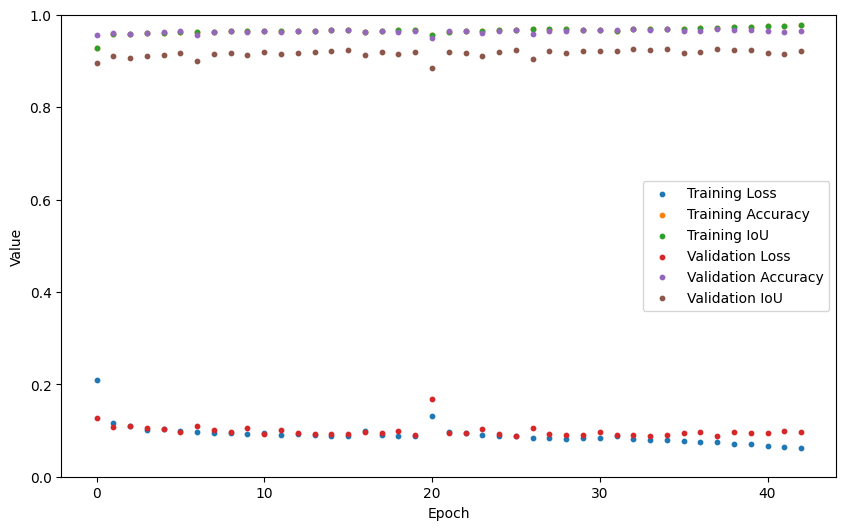

In [9]:
plot_metrics(['loss', 'accuracy', 'iou', 'val_loss', 'val_accuracy', 'val_iou'], history, [0,1])

Max training iou: 0.9464308619499207
Max validation iou: 0.9260575771331787


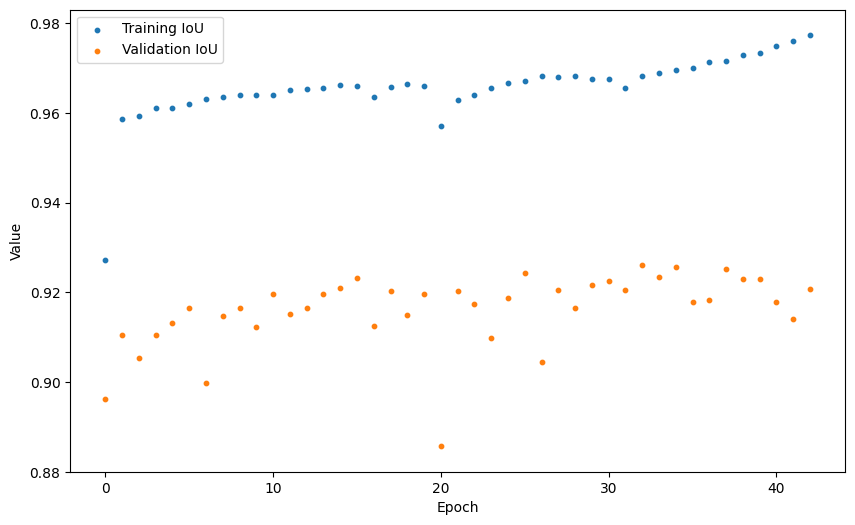

In [13]:
plot_metrics(['iou', 'val_iou'], history, [0.88,0.983])

Min training loss: 0.06186676025390625
Min validation loss: 0.08786363899707794


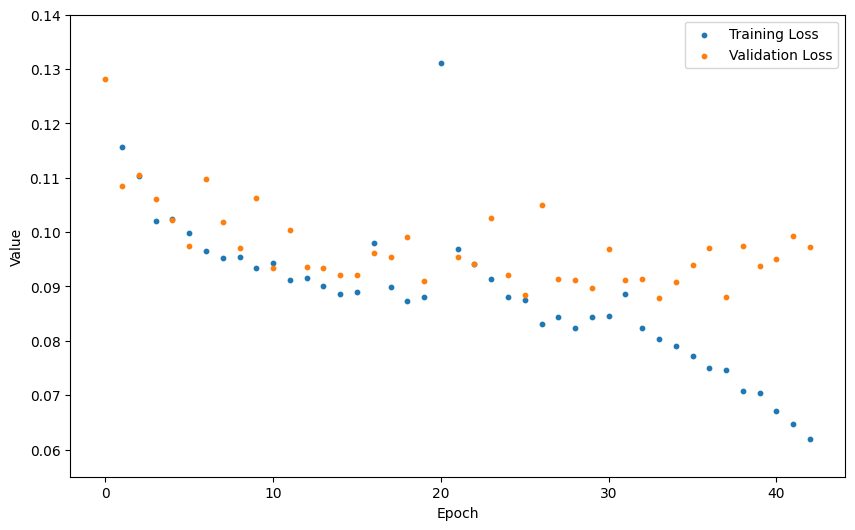

In [17]:
plot_metrics(['loss', 'val_loss',], history, [0.055, 0.14])

Max training accuracy: 0.9772986769676208
Max validation accuracy: 0.9684195518493652


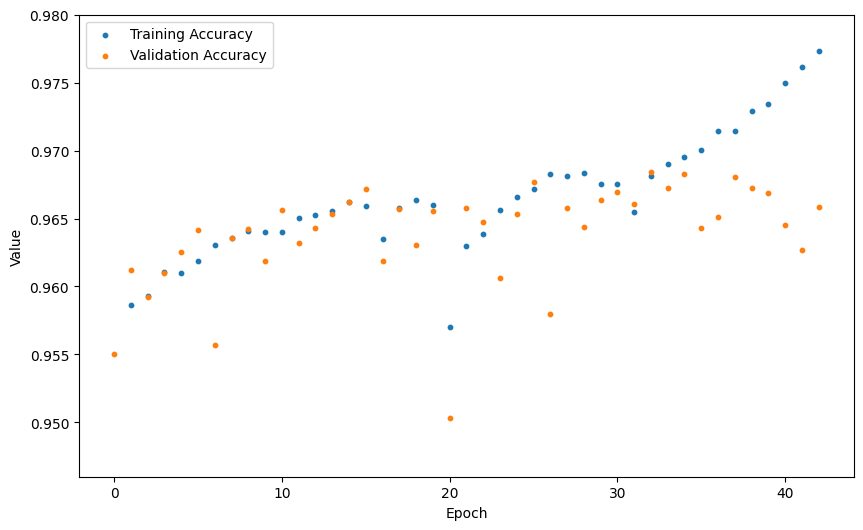

In [21]:
plot_metrics(['accuracy', 'val_accuracy'], history, [0.946, 0.98])

### Summary

In [43]:
def _load_metrics(model_range, experiment, ending: str = None):
    metrics = []
    path = f'../metrics/{experiment}'
    for model in range(model_range[0], model_range[1]):
        for dataset in ['train', 'val', 'test']:
            file = f'metrics_{dataset}_{model}.pkl'
            if ending:
                file = f'metrics_{dataset}_{ending}.pkl'
            print(f'opening file: {os.path.join(path, file)}')
            with open(os.path.join(path, file), "rb") as f:
                m = pickle.load(f)
                m_dict = m.__dict__
                del m_dict['cm_invalid']
                del m_dict['cm_valid']
                del m_dict['cm_land']
                metrics.append((m_dict, file))
                print(m_dict)
                print(file)
    return metrics
#metrics = _load_metrics(2, experiment)

def load_metrics_into_df(model_range, experiment, title, ending=None):
    metrics = _load_metrics(model_range, experiment, ending)
    metrics_dicts = []
    metric_names = []
    for metric in metrics:
        metrics_dicts.append(metric[0])
        name_split = metric[1].split('_')
        metric_names.append(f'{name_split[1]}_{name_split[2][0]}')

    df = pd.DataFrame(metrics_dicts)
    df.index = metric_names
    df = df.transpose()

    df.style.set_table_attributes("style='display:inline'").set_caption(
        title).set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'white'),
            ('font-size', '20px')
        ]
    }])
    df.index.name = 'Evaluation Metrics'

    return df

In [45]:
df = load_metrics_into_df([1,2], experiment, 'test')

opening file: ../metrics/experiment_6/metrics_train_1.pkl
{'iou_invalid': 0.88047737, 'iou_valid': 0.91478926, 'iou_land': 0.9982509, 'mean_iou': 0.9311725298563639, 'precision_invalid': 0.95886886, 'precision_valid': 0.9403524, 'precision_land': 0.9986799, 'recall_invalid': 0.9150369, 'recall_valid': 0.9711408, 'recall_land': 0.99956983, 'specificity_invalid': 0.98785996, 'specificity_valid': 0.9713205, 'specificity_land': 0.9989359, 'f1_invalid': 0.9364402883558471, 'f1_valid': 0.9554986678153218, 'f1_land': 0.999124700334861, 'accuracy_invalid': 0.970657, 'accuracy_valid': 0.9712634, 'accuracy_land': 0.9992187}
metrics_train_1.pkl
opening file: ../metrics/experiment_6/metrics_val_1.pkl
{'iou_invalid': 0.87120575, 'iou_valid': 0.90887666, 'iou_land': 0.9980909, 'mean_iou': 0.9260578155517578, 'precision_invalid': 0.956747, 'precision_valid': 0.9351745, 'precision_land': 0.9985975, 'recall_invalid': 0.90692574, 'recall_valid': 0.9699884, 'recall_land': 0.999492, 'specificity_invalid':

In [46]:
df

train_1     val_1    test_1
Evaluation Metrics                               
iou_invalid          0.880477  0.871206  0.884363
iou_valid            0.914789  0.908877  0.918580
iou_land             0.998251  0.998091  0.998174
mean_iou             0.931173  0.926058  0.933706
precision_invalid    0.958869  0.956747  0.953950
precision_valid      0.940352  0.935175  0.947353
precision_land       0.998680  0.998598  0.998661
recall_invalid       0.915037  0.906926  0.923802
recall_valid         0.971141  0.969988  0.967994
recall_land          0.999570  0.999492  0.999511
specificity_invalid  0.987860  0.987437  0.986394
specificity_valid    0.971321  0.968750  0.974484
specificity_land     0.998936  0.998860  0.998928
f1_invalid           0.936440  0.931170  0.938634
f1_valid             0.955499  0.952263  0.957562
f1_land              0.999125  0.999045  0.999086
accuracy_invalid     0.970657  0.968554  0.971762
accuracy_valid       0.971263  0.969143  0.972396
accuracy_land        0.999219  0.999143  0.999187

training iou from the start better than validation iou => overfitting


In [51]:
y_true = tf.constant([[0, 0, 1], [1, 0, 0], [0, 1, 0], [1, 0, 0]])
y_pred = tf.constant([[0.2, 0.3, 0.5], [0.1, 0.2, 0.7], [0.5, 0.3, 0.1],
                      [0.1, 0.4, 0.5]])

m = tf.keras.metrics.OneHotIoU(num_classes=3, target_class_ids=[2])
m.update_state(y_true=y_true, y_pred=y_pred)
m.result().numpy()



TypeError: ignored